# ✅Step 6: Analysis of Ingredients and Cuisines

## 🎯0. Import libraries and load data

In [41]:
import pandas as pd
import numpy as np
import sys
from plotnine import *
import altair as alt

# Import our own modules
sys.path.append("../scripts/")
import chadtools

In [42]:
df = pd.read_json("../data/merged_data_for_analysis.json", orient="records")
df.head(3)

,id,title,gpt_ingredients,cuisine,ingredient_comment,score,upvote_ratio,link_flair_text,author,created_utc,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
0,1ah8m5s,Thai Green Curry Chicken Satay,"[chicken satay, homemade green curry paste, ve...",thai,You could use any curry paste you like. Do you...,49,0.879883,Recipe,butchec,1706893611000,...,Thai green chicken curry,257,0.60,15.0,3.0,10.0,9.0,19.0,2.0,0.90
1,1afoma3,Sweet and Sour Tofu,"[tofu, ground black pepper, salt, cornstarch, ...",chinese,I love figuring out ways to make tofu deliciou...,59,0.890137,Recipe,parisrosaries,1706725321000,...,Sweet & sour tofu,530,1.20,17.0,18.0,2.0,75.0,15.0,8.0,0.82
2,1acagoz,Chocolate Fudgy Brownie,"[butter, dark chocolate, cocoa powder, white s...",american,Full Chocolate Fudgy Brownie recipe: https://w...,114,0.910156,Recipe,butchec,1706360858000,...,Fudgy brownies,1043,0.62,62.0,76.0,35.0,105.0,14.0,6.0,0.86


## 🎯1. Analysis of Ingredients

We first do some ingredient analysis for all the recipes. In particular, we are interested in finding how much of the *top 10 most common ingredients* are used in each cuisine.

In [43]:
all_ingredient_list = []
for i in df["gpt_ingredients"].tolist():
    all_ingredient_list.extend(i)

all_ingredient_series = pd.Series(all_ingredient_list)
top_10_ingredients = all_ingredient_series.value_counts().head(10)

In [44]:
top_10_ingredients

salt            347
pepper          140
garlic          131
butter          127
sugar            91
olive oil        89
water            81
black pepper     65
eggs             63
yellow onion     63
Name: count, dtype: int64

In [45]:
ingredient_frequency_df = pd.DataFrame(top_10_ingredients).reset_index()
ingredient_frequency_df.columns = ["ingredient", "frequency"]
ingredient_frequency_df = ingredient_frequency_df.sort_values("frequency", ascending=False)

In [46]:
plot = (ggplot(ingredient_frequency_df, aes(x="ingredient", y="frequency")) +
       geom_bar(stat="identity", fill='#5c3da4') +
       coord_flip() +
       scale_x_discrete(limits=ingredient_frequency_df["ingredient"][::-1]) +
       theme(plot_title = element_text(weight='bold', color="black", size=10, ha="right")) +
       theme(aspect_ratio=9/16) +
       labs(title="Top 10 ingredients by frequency in both BBC GoodFood and Reddit recipes", 
            x="Ingredient", y="Number of recipes")
)
plot.save("../plots/top_10_ingredients_frequency.jpg", format="jpg", dpi=600)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/top_10_ingredients_frequency.jpg


Hence, the top 10 ingredients found in recipes appearing on both BBC GoodFood and Reddit are:
1. Salt
2. Pepper
3. Garlic
4. Butter
5. Sugar
6. Olive oil
7. Water
8. Black Pepper
9. Eggs
10. Yellow Onion

## 🎯2. Analysis of Cuisines

We are also interested in the breakdown of cuisines in the recipes.

In [47]:
# get the top 10 cuisines by frequency 
cuisine_counts = df["cuisine"].value_counts().reset_index()
cuisine_counts.columns = ["cuisine", "count"]
cuisine_counts = cuisine_counts.sort_values("count", ascending=False)
cuisine_counts.head(10)

,cuisine,count
0,italian,111
1,american,70
2,chinese,35
3,thai,32
4,french,25
5,japanese,21
6,indian,18
7,british,17
8,mexican,16
9,greek,12


In [48]:
# if the recipe is in the top 10, keep it, otherwise set it to "other"
df["cuisine"] = df["cuisine"].apply(lambda x: x if x in cuisine_counts["cuisine"].values[:10] else "other")

df.head()

,id,title,gpt_ingredients,cuisine,ingredient_comment,score,upvote_ratio,link_flair_text,author,created_utc,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
0,1ah8m5s,Thai Green Curry Chicken Satay,"[chicken satay, homemade green curry paste, ve...",thai,You could use any curry paste you like. Do you...,49,0.879883,Recipe,butchec,1706893611000,...,Thai green chicken curry,257,0.60,15.0,3.0,10.0,9.0,19.0,2.0,0.90
1,1afoma3,Sweet and Sour Tofu,"[tofu, ground black pepper, salt, cornstarch, ...",chinese,I love figuring out ways to make tofu deliciou...,59,0.890137,Recipe,parisrosaries,1706725321000,...,Sweet & sour tofu,530,1.20,17.0,18.0,2.0,75.0,15.0,8.0,0.82
2,1acagoz,Chocolate Fudgy Brownie,"[butter, dark chocolate, cocoa powder, white s...",american,Full Chocolate Fudgy Brownie recipe: https://w...,114,0.910156,Recipe,butchec,1706360858000,...,Fudgy brownies,1043,0.62,62.0,76.0,35.0,105.0,14.0,6.0,0.86
3,19d0wfc,Buffalo Chicken Tenders,"[chicken tenderloins, flour, garlic powder, eg...",american,**Recipe here originally:** [**Buffalo Chicken...,275,0.970215,Recipe,BushyEyes,1705944195000,...,Buffalo chicken,520,7.40,35.0,11.0,15.0,11.0,39.0,3.0,0.88
4,1998zka,Prawn Katsu Baos,"[kewpie, plain yoghurt, dill pickles, capers, ...",japanese,This one is high impact and a showstopper for ...,291,0.950195,Recipe,TheLuckiestDragon,1705528588000,...,Prawn katsu burgers,1070,2.80,74.0,13.0,12.0,68.0,30.0,6.0,0.90


## 🎯3. Putting both together

### 3.1 Frequency of top 10 ingredients in different cuisines

What ingredients feature prominently in each cuisine? We will put the top 10 ingredients and cuisines together to find out. We group the recipes by cuisines and find the mean quantity of each nutrient for the top 10 cuisines.

In [62]:
# for each ingredient, get the frequency of each cuisine
cuisine_ingredient_df = pd.DataFrame()
for ingredient in ingredient_frequency_df["ingredient"]:
    ingredient_df = df[df["gpt_ingredients"].apply(lambda x: ingredient in x)]
    cuisine_counts = ingredient_df["cuisine"].value_counts().reset_index()
    cuisine_counts.columns = ["cuisine", "count"]
    cuisine_counts["ingredient"] = ingredient
    cuisine_ingredient_df = pd.concat([cuisine_ingredient_df, cuisine_counts])

cuisine_ingredient_df

,cuisine,count,ingredient
0,other,89,salt
1,italian,70,salt
2,american,48,salt
3,thai,16,salt
4,chinese,15,salt
...,...,...,...
3,mexican,4,yellow onion
4,thai,3,yellow onion
5,chinese,2,yellow onion
6,indian,2,yellow onion


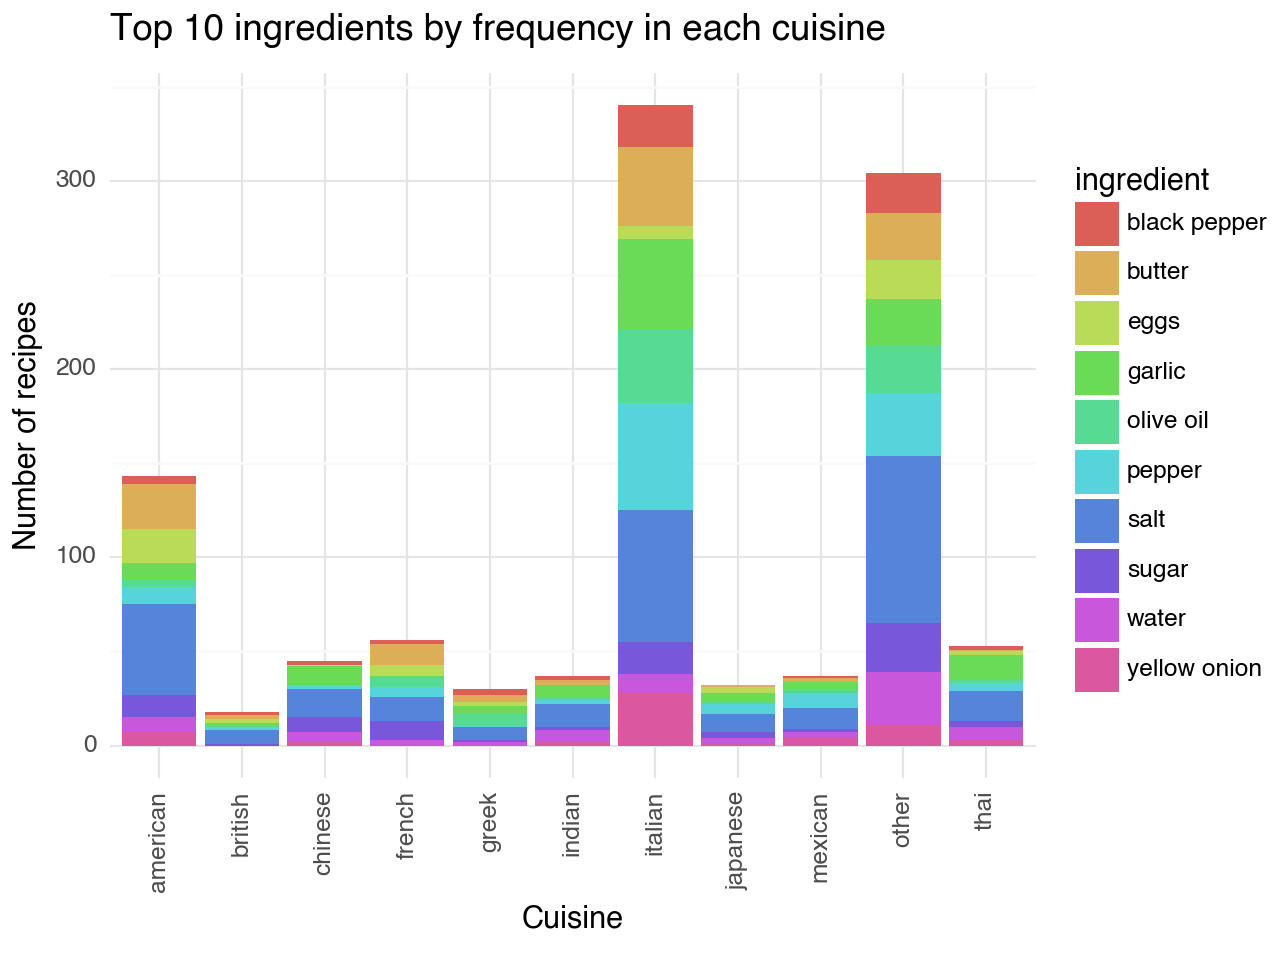

<Figure Size: (640 x 480)>

In [59]:
# plot a stacked bar chart of the top 10 ingredients and how often they appear in each cuisine
plot = (ggplot(cuisine_ingredient_df, aes(x="cuisine", y="count", fill="ingredient")) +
       geom_bar(stat="identity") +
       theme_minimal() +
       theme(axis_text_x=element_text(angle=90)) +
       labs(title="Top 10 ingredients by frequency in each cuisine", x="Cuisine", y="Number of recipes")
)  
plot 

In [50]:
# cross tabulate the data to show the frequency of each ingredient in each cuisine
final_cuisine_ingredient_df = cuisine_ingredient_df.pivot(index="cuisine", columns="ingredient", values="count")
final_cuisine_ingredient_df = final_cuisine_ingredient_df.fillna(0)
final_cuisine_ingredient_df = final_cuisine_ingredient_df.astype(int)

# Reset column index to remove "ingredient" label
final_cuisine_ingredient_df.columns.name = None
final_cuisine_ingredient_df = final_cuisine_ingredient_df.reset_index()

final_cuisine_ingredient_df

,cuisine,black pepper,butter,eggs,garlic,olive oil,pepper,salt,sugar,water,yellow onion
0,american,4,24,18,9,4,9,48,12,8,7
1,british,2,2,2,1,1,2,7,1,0,0
2,chinese,2,0,1,10,0,2,15,8,5,2
3,french,2,11,6,1,5,5,13,10,3,0
4,greek,3,4,2,4,6,1,7,1,2,0
5,indian,2,3,0,7,1,2,12,2,6,2
6,italian,22,42,7,48,39,57,70,17,10,28
7,japanese,0,1,3,5,1,5,10,3,3,1
8,mexican,1,2,0,4,2,8,11,2,3,4
9,other,21,25,21,25,25,33,89,26,28,11


### 3.2 Mean nutrition data for top 10 cuisines 

In [57]:
nutrients = ["calories", "carbs", "fat", "protein", "saturates", "sugars", "fibre", "salt"]
top_10_cuisines = df["cuisine"].value_counts().head(10)

cuisines_nutrients_df = df[["cuisine"] + nutrients].groupby(["cuisine"]).mean().filter(top_10_cuisines.index, axis=0)
cuisines_nutrients_df

,calories,carbs,fat,protein,saturates,sugars,fibre,salt
cuisine,,,,,,,,
other,420.083916,36.110490,21.027273,19.361538,8.286713,14.931469,3.800699,1.022238
italian,549.126126,53.207207,24.567568,27.126126,10.195495,7.810811,5.415315,1.276396
american,405.042857,37.977143,21.842857,13.134286,10.795714,22.100000,2.360000,1.079143
chinese,358.428571,26.342857,16.600000,24.971429,5.314286,6.894286,3.425714,1.626000
thai,376.156250,22.631250,20.406250,25.468750,7.937500,8.500000,3.325000,1.630313
french,497.120000,38.656000,30.680000,16.672000,13.708000,23.760000,2.280000,0.800000
japanese,355.904762,30.776190,18.285714,15.571429,5.714286,10.961905,3.890476,1.490476
indian,380.333333,27.944444,19.666667,21.277778,9.111111,11.500000,6.333333,0.978889
british,504.294118,51.264706,26.217647,17.005882,12.205882,21.941176,2.605882,1.007059


To plot a radar chart, will use the `ggradar` library in R. To show the relative amount of each ingredient among the cuisines, we need to normalise the quantities with a min-max scaling method.

In [52]:
cuisines_nutrients_df_normalised = pd.DataFrame()
for nutrient in nutrients:
    series = cuisines_nutrients_df[nutrient]
    normalized_series = (series - series.min()) / (series.max() - series.min()) # apply min-max scaling
    cuisines_nutrients_df_normalised[nutrient] = normalized_series # add normalised column

In [53]:
cuisines_nutrients_df_normalised

,calories,carbs,fat,protein,saturates,sugars,fibre,salt
cuisine,,,,,,,,
other,0.332154,0.440844,0.314437,0.394050,0.354125,0.476540,0.340201,0.267656
italian,1.000000,1.000000,0.565878,0.885379,0.581532,0.054343,0.701413,0.573756
american,0.254310,0.501894,0.372362,0.000000,0.653040,0.901575,0.017897,0.336190
chinese,0.013062,0.121390,0.000000,0.749034,0.000000,0.000000,0.256312,0.994806
thai,0.104810,0.000000,0.270330,0.780504,0.312521,0.095206,0.233781,1.000000
french,0.730847,0.524096,1.000000,0.223860,1.000000,1.000000,0.000000,0.000000
japanese,0.000000,0.266384,0.119724,0.154218,0.047655,0.241177,0.360286,0.831586
indian,0.126428,0.173770,0.217803,0.515306,0.452342,0.273081,0.906786,0.215448
british,0.767976,0.936470,0.683072,0.244988,0.821043,0.892159,0.072904,0.249375


### Save to CSV to use in R

In [54]:
cuisines_nutrients_df_normalised.to_csv("../data/top10cuisines_nutrients_normalised.csv")

The code for visualisation can be found in [radar_plots.r](../scripts/radar_plots.r)